# Align Vectors

In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import gensim
import glob

import src.procrustes
import src.ud_corpus

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
vecs_classical = gensim.models.KeyedVectors.load_word2vec_format('../data/glove/classical-chinese/vectors.txt', binary=False)
vecs_modern = gensim.models.KeyedVectors.load_word2vec_format('../data/glove/modern-chinese/vectors.txt', binary=False)

In [3]:
print(len(vecs_classical.vocab))
print(len(vecs_modern.vocab))

8418
11042


In [4]:
vecs_classical.most_similar('也')

[('此', 0.6211493015289307),
 ('之', 0.5966967344284058),
 ('矣', 0.5865829586982727),
 ('非', 0.5838754177093506),
 ('亦', 0.5630781650543213),
 ('則', 0.5609027147293091),
 ('不', 0.5547611117362976),
 ('可', 0.5543578267097473),
 ('？', 0.5412447452545166),
 ('君', 0.5396000146865845)]

In [5]:
vecs_modern.most_similar('也')

[('但', 0.7273572683334351),
 ('此', 0.6991831660270691),
 ('而', 0.697770357131958),
 ('是', 0.6840647459030151),
 ('的', 0.6499351859092712),
 ('就', 0.6348243355751038),
 ('不', 0.6340436935424805),
 ('且', 0.6330309510231018),
 ('他', 0.6328660249710083),
 ('些', 0.6294775605201721)]

In [6]:
vecs_modern = src.procrustes.smart_procrustes_align_gensim(vecs_classical, vecs_modern)

In [7]:
shared_vocab = set(vecs_classical.vocab.keys()) & set(vecs_modern.vocab.keys())

## Calculate amount of change for shared vocab

In [8]:
ud_data = src.ud_corpus.POSCorpus.create_from_ud(glob.glob('../data/UD_Classical_Chinese-Kyoto/*.conllu'))

In [9]:
summary_data = ud_data.get_nv_stats().sort_values('total_count', ascending=False)
summary_data = summary_data[summary_data.total_count >= 5]
summary_data = summary_data[summary_data.char.isin(shared_vocab)]
summary_data['semantic_change'] = summary_data.char.apply(
  lambda c: np.linalg.norm(vecs_classical[c] - vecs_modern[c])
)
summary_data

,char,noun_count,verb_count,total_count,noun_ratio,semantic_change
6,曰,0,2065,2065,0.000000,1.013179
5,子,1421,8,1429,0.994402,0.953451
21,人,1163,0,1163,1.000000,0.839036
14,有,0,967,967,0.000000,1.005577
72,以,0,862,862,0.000000,0.908980
...,...,...,...,...,...,...
1434,羹,5,0,5,1.000000,1.056849
1433,菜,5,0,5,1.000000,0.974572
1168,夕,5,0,5,1.000000,1.113150
598,嗜,0,5,5,0.000000,0.971940


## Print words with most and least change

In [10]:
summary_data.sort_values("semantic_change", ascending=False).head(15)

,char,noun_count,verb_count,total_count,noun_ratio,semantic_change
951,纳,0,9,9,0.000000,1.427509
638,术,7,0,7,1.000000,1.414176
237,别,0,21,21,0.000000,1.396339
781,适,0,17,17,0.000000,1.386691
152,复,0,14,14,0.000000,1.383630
44,与,0,90,90,0.000000,1.383342
132,异,0,42,42,0.000000,1.370065
1061,着,0,9,9,0.000000,1.353356
907,筑,1,5,6,0.166667,1.339770
1167,党,29,3,32,0.906250,1.333421


In [11]:
summary_data.sort_values("semantic_change").head(15)

,char,noun_count,verb_count,total_count,noun_ratio,semantic_change
568,南,24,1,25,0.960000,0.721037
613,水,64,0,64,1.000000,0.739562
337,山,29,0,29,1.000000,0.751939
733,病,15,16,31,0.483871,0.766609
158,食,59,138,197,0.299492,0.773277
486,河,12,0,12,1.000000,0.778131
377,罪,43,12,55,0.781818,0.781502
223,死,29,86,115,0.252174,0.786616
908,城,10,0,10,1.000000,0.790459
266,女,29,2,31,0.935484,0.794239


/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Noun ratio')

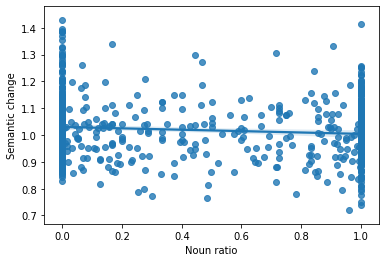

In [12]:
sns.regplot(summary_data.noun_ratio, summary_data.semantic_change)
plt.ylabel('Semantic change')
plt.xlabel('Noun ratio')

In [13]:
scipy.stats.pearsonr(summary_data.noun_ratio, summary_data.semantic_change)

(-0.10023252475241008, 0.008048168860609384)

Text(0.5, 0, 'Log frequency')

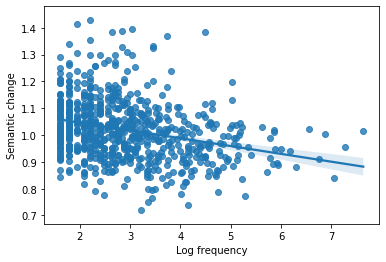

In [14]:
sns.regplot(np.log(summary_data.total_count), summary_data.semantic_change)
plt.ylabel('Semantic change')
plt.xlabel('Log frequency')

In [15]:
scipy.stats.pearsonr(np.log(summary_data.total_count), summary_data.semantic_change)

(-0.2828194221325998, 2.644930758465029e-14)